In [1]:
import nplab.datafile as df
import os
import numpy as np
import sklearn.preprocessing as skpre
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import datetime
import h5py
import scipy.signal as sig
from scipy.stats import skew
from scipy.stats import iqr
import matplotlib.cm as cm
import Alexsdatafuncs
datman = Alexsdatafuncs.data_manipulators()
from pandas import DataFrame
import peakutils
import scipy.constants as const
from lmfit.models import GaussianModel
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from matplotlib.ticker import FormatStrFormatter
import pandas as pd
from matplotlib.collections import LineCollection

In [2]:
reload(Alexsdatafuncs)
datman = Alexsdatafuncs.data_manipulators()
alexplot = Alexsdatafuncs.plotting_funcs()

In [3]:
#Colour schemes to use
colours = cm.viridis(np.linspace(0,1,100)) 
colours_2 = cm.hot(np.linspace(0,1,100))

In [4]:
if 'hf' in globals():
    hf.close
    print "File closed"
elif 'data_f' in globals():
    data_f.close
else:
    print "No hdf5 file open"
    pass

No hdf5 file open


In [ ]:
#There are two ways to open the file but both use h5py. If nplab.datafile is used the data is sorted automatically by
# timestamp, whereas h5py defaults to sort alphabetically

if 'hf' in globals():
    hf.close
    print "File closed"
else:
    pass

os.chdir('C:/Users/alexc/OneDrive - University of Cambridge/Documents/PhD Project/Projects')
data_f = df.open_file(set_current_bool=False, mode = 'r')

if data_f != None:
    data_f.show_gui()
    filoc = data_f.filename
    data_f.close()
else:
    pass

In [6]:
# create or open an HDF5 file and open in read mode
if 'filoc' not in globals():
    hf = h5py.File('C:\\Users\\alexc\\OneDrive - University of Cambridge\\Documents\\PhD Project\\Projects\\Boron Nitride spacer\\Trilayer hBN\\2019-02-27_051118_tri3_60nmNPs_2.h5', 'r')
else:
    hf = h5py.File(filoc, 'r')
# open dark field data as an list hdf5 object
dfdata = hf.get('OceanOpticsSpectrometer')
# open image data as a list hdf5 object
imdata = hf.get('LumeneraCamera')

In [7]:
# set background, wavelength, reference and timestamp
dat0 = dfdata.get(dfdata.keys()[0])
numspec = len(dfdata.keys())
numpnts = len(dat0)
bgd = dat0.attrs['background']
wls = dat0.attrs['wavelengths']
ts = dat0.attrs['creation_timestamp']

In [8]:
# initialise matrix for dark field, timestamp and combined
dfmat = []
tsmat = []
dfmatwts = []

In [9]:
# Append into matrices the data with it properly referenced
i = 0
for i in range(0, numspec):
    temp = dfdata.get(dfdata.keys()[i])
    temparr = np.array(temp)
    dfield = (temparr - bgd) / (temp.attrs['reference'] - bgd)
    dfmat.append(dfield)
    ts = datetime.datetime.strptime(temp.attrs['creation_timestamp'][:19],
                                    "%Y-%m-%dT%H:%M:%S")
    dfwts = np.append(dfield, ts)  # append the timestamp to the end of the dataset
    dfmatwts.append(dfwts)

In [10]:
# If the data isn't already sorted by timestamp then this will sort it in this way
# sort by the end timestamp value and then delete the timestamp column

dfmatwts.sort(key=lambda row: row[-1:])

In [12]:
# Paste the threshold time from the gui into variable tsthreshold and this will split into two seperate datasets

tsthreshold_1 = datetime.datetime.strptime("2019-02-27T14:46:53.951000", "%Y-%m-%dT%H:%M:%S.%f")

dfon = []
i=0
for i in range(0, len(dfmatwts)):
    if dfmatwts[i][-1] > tsthreshold_1:
        dfon.append(dfmatwts[i])
    else:
        pass

dfonsorted = np.delete(dfon, -1, axis=1)


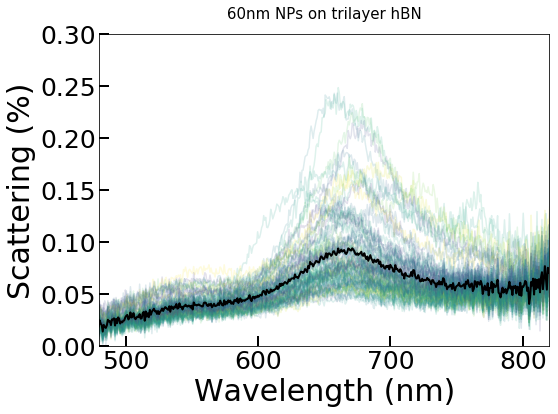

In [34]:
fig, ax, avdf_on = alexplot.plot_all_df(spectra=dfonsorted, wls=wls, colours=colours)
ax.set_title('60nm NPs on trilayer hBN', fontsize=15, pad=15)
ax.set_ylim(0,0.3)
ax.set_xlim(480,820)

plt.tight_layout(pad=1.6)
fig.savefig('C:\\Users\\alexc\\OneDrive - University of Cambridge\\Documents\\PhD Project\\Projects\\Boron Nitride spacer\\Trilayer hBN\\60nm NPs on tri_mono hBN\\60nm NPs on trilayer hBN all and avg.jpg')

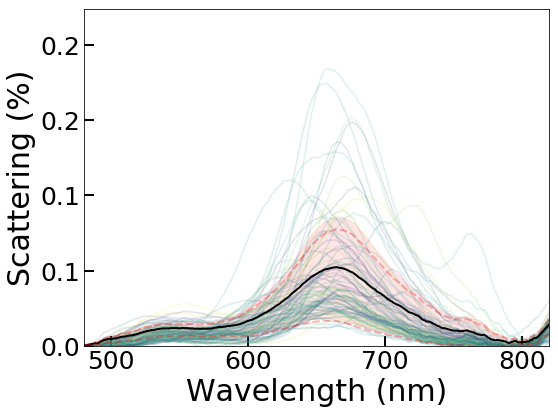

In [39]:
fig, ax, dfon_filt,avdf_on_filt, wls_cr, std_on_filt = alexplot.plot_all_smooth_df(spectra=dfonsorted, wls=wls, colours=colours, baseline_subtract=1, order=1, start_wl=480, end_wl=820)
#ax.set_ylim(0,0.2)

fig.savefig('C:\\Users\\alexc\\OneDrive - University of Cambridge\\Documents\\PhD Project\\Projects\\Boron Nitride spacer\\Trilayer hBN\\60nm NPs on tri_mono hBN\\60nm NPs on trilayer hBN all and avg smooth.jpg')

spectra same length


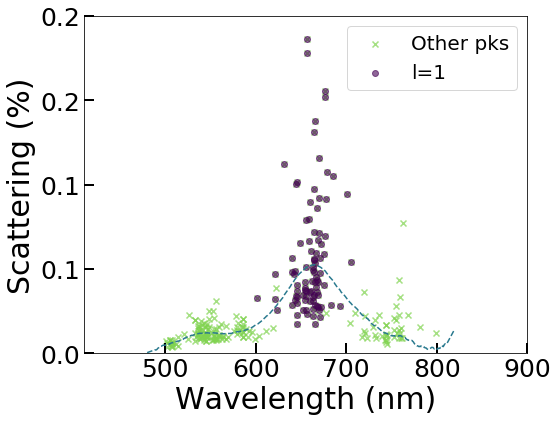

In [36]:
fig, ax, dfon_pk_wls, dfon_pk_ints, dfon_pkwls_vec, dfon_pkints_vec,\
l1_only_ints_on, l1_only_wls_on = alexplot.plot_all_peaks(spectra=dfon_filt, wls=wls_cr, colours=colours, threshold=0.02, start_wl=500, end_wl=800)
arg_zero = np.argwhere(l1_only_wls_on == np.min(l1_only_wls_on))[0][0]
l1_only_ints_on = np.delete(l1_only_ints_on, arg_zero)
l1_only_wls_on = np.delete(l1_only_wls_on, arg_zero)
ax.set_ylim(0,0.2)
ax.legend(fontsize=20)
fig.savefig('C:\\Users\\alexc\\OneDrive - University of Cambridge\\Documents\\PhD Project\\Projects\\Boron Nitride spacer\\Trilayer hBN\\60nm NPs on tri_mono hBN\\60nm NPs on trilayer hBN peaks.jpg')

-0.10125030464812511

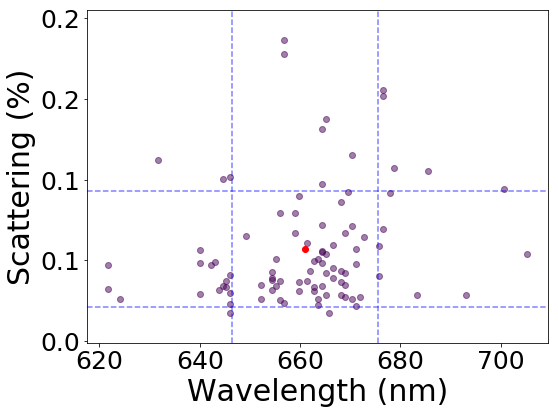

In [37]:
# plotting the peak positions of all peaks with highest intensity for each spectrum

fig = plt.figure(1, figsize=(8,6))
ax = fig.add_subplot(111)
ax.scatter(l1_only_wls_on, l1_only_ints_on*100, alpha=0.5, color=colours[0])
mean_dipole_on = np.mean(l1_only_wls_on)
mean_dipole_on_int = np.mean(l1_only_ints_on*100)
ax.scatter(mean_dipole_on, mean_dipole_on_int, color='r')
std_dipole_on = np.std(l1_only_wls_on)
std_dipole_on_int = np.std(l1_only_ints_on*100)
ax.axvline(mean_dipole_on+std_dipole_on, linestyle='--', color='blue',alpha=0.5)
ax.axvline(mean_dipole_on-std_dipole_on, linestyle='--', color='blue', alpha=0.5)
ax.axhline(mean_dipole_on_int+std_dipole_on_int, linestyle='--', color='blue', alpha=0.5)
ax.axhline(mean_dipole_on_int-std_dipole_on_int, linestyle='--', color='blue', alpha=0.5)
ax.set_ylabel("Scattering (%)", fontsize=30)
ax.set_xlabel("Wavelength (nm)", fontsize=30)
ax.tick_params(labelsize=25)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
plt.tight_layout(pad=1.6)
#fig.savefig('C:\\Users\\alexc\\OneDrive - University of Cambridge\\Documents\\PhD Project\\Projects\\Boron Nitride spacer\\Monolayer hBN data for thesis\\Monolayer hBN on Au\\2018-11-05_sample1_60nmNPs_NaCl_cont analysis\\60nm NPs on mono hBN maxint peak dist')
skew(l1_only_wls_on)

In [33]:
mean_dipole_on

660.938246861293